In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

In [5]:
from src import analysis, data, simulation, viz

In [5]:
from tvb.simulator.lab import *

2020-10-21 13:24:16,244 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/home/izaak/local_repos/nostromo/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [19]:
def plot_ts_stack(data,scale=0.9, lw=0.4, title=None, labels=None):
    """Plot the multivariate time series stacked vertically.

    Parameters
    ----------
    data : ndarray
        time series of shape [time,nodes]
    scale : float
        amplitude scaling factor
    lw : float
        line width
    title : str
        title of the plot
    labels : list of str
        node labels
    """
    data = data - np.mean(data, axis=1, keepdims=True)
    maxrange = np.max(np.max(data, axis=1) - np.min(data, axis=1))
    data /= maxrange

    n_nodes = data.shape[1]
    fig, ax = plt.subplots(figsize=(48,0.5*n_nodes))
    for i in range(n_nodes):
        ax.plot(scale*data[:, i] + i, 'k', lw=lw)
    ax.autoscale(enable=True, axis='both', tight=True)
    if title is not None:
        ax.set_title(title)

    if labels is None:
        labels = np.r_[:n_nodes]
    ax.set_yticks(np.r_[:n_nodes])
    ax.set_yticklabels(labels)


In [144]:
from tvb.simulator.models import fast_montbrio

In [155]:
def uniform_ic(t,rV):
    rV[0] = np.random.uniform(
        low=models.MontbrioPazoRoxin().state_variable_range['r'][0],
        high=models.MontbrioPazoRoxin().state_variable_range['r'][1],
        size=rV[0].shape
    )
    rV[1] = np.random.uniform(
        low=models.MontbrioPazoRoxin().state_variable_range['V'][0],
        high=models.MontbrioPazoRoxin().state_variable_range['V'][1],
        size=rV[1].shape
    )

In [202]:
def run_fast(sim, bold_tr=1800, nh=1024,nto=64, icfun=uniform_ic):
    tavg, bold = fast_montbrio.run_loop(
        weights=sim.connectivity.weights,
        delays=sim.connectivity.delays,
        total_time=sim.simulation_length,
        bold_tr=1800,
        coupling_scaling=sim.coupling.a.item(),
        r_sigma=sim.integrator.noise.gfun(None)[0].item(),
        V_sigma=sim.integrator.noise.gfun(None)[1].item(),
        I=sim.model.I.item(),
        Delta=sim.model.Delta.item(),
        eta=sim.model.eta.item(),
        tau=sim.model.tau.item(),
        J=sim.model.J.item(),
        cr=sim.model.cr.item(),
        cv=sim.model.cv.item(),
        dt=sim.integrator.dt/10,
        nh=nh,
        nto=nto,
        progress=False,
        icfun=icfun,
    )
    return tavg, bold

In [86]:
conn_speed=2.0
dt=0.01
seed=42
nsigma=0.01
eta=-4.6
J=14.5
Delta=0.7
tau=1

In [91]:
G=0.1

conn = connectivity.Connectivity.from_file() # default 76 regions 
conn.speed = np.array([conn_speed])  
np.fill_diagonal(conn.weights, 0.)
conn.weights = conn.weights/np.max(conn.weights)
conn.configure()

sim = simulator.Simulator(
    model=models.MontbrioPazoRoxin(
        eta   = np.r_[eta],
        J     = np.r_[J],
        Delta = np.r_[Delta],
        tau = np.r_[tau],
    ),
    connectivity=conn,
    coupling=coupling.Scaling(
      a=np.r_[G]
    ),
    conduction_speed=conn_speed,
    integrator=integrators.HeunStochastic(
      dt=dt,
      noise=noise.Additive(
          nsig=np.r_[nsigma, nsigma*2],
          noise_seed=seed
      )
    ),
    monitors=[
      monitors.TemporalAverage(period=1.),    
      monitors.ProgressLogger(period=100)
    ]
)

sim.configure()

WARNING  File 'hemispheres' not found in ZIP.


,value
Type,Simulator
conduction_speed,2.0
connectivity,Connectivity gid: 4fbbd506-0a3c-44a6-a54e-aaf37ec96458
coupling,Scaling gid: 0eae4191-d339-4c22-bfbb-ba1dd00e9c16
gid,UUID('2d07ea83-0bc3-45fe-938b-bb0a4b4019b7')
initial_conditions,None
integrator,HeunStochastic gid: 3e8fe735-9345-44c3-9aab-d19820e4fc16
model,MontbrioPazoRoxin gid: c61f78c6-ac09-419e-8757-35f929bb432f
monitors,"[, ]"
simulation_length,1000.0


In [92]:
(tavg_t, tavg_d), _ = sim.run(simulation_length=1000)

   INFO  step 1 time 0.0000 s
   INFO  step 10001 time 0.1000 s
   INFO  step 20001 time 0.2000 s
   INFO  step 30001 time 0.3000 s
   INFO  step 40001 time 0.4000 s
   INFO  step 50001 time 0.5000 s
   INFO  step 60001 time 0.6000 s
   INFO  step 70001 time 0.7000 s
   INFO  step 80001 time 0.8000 s
   INFO  step 90001 time 0.9000 s


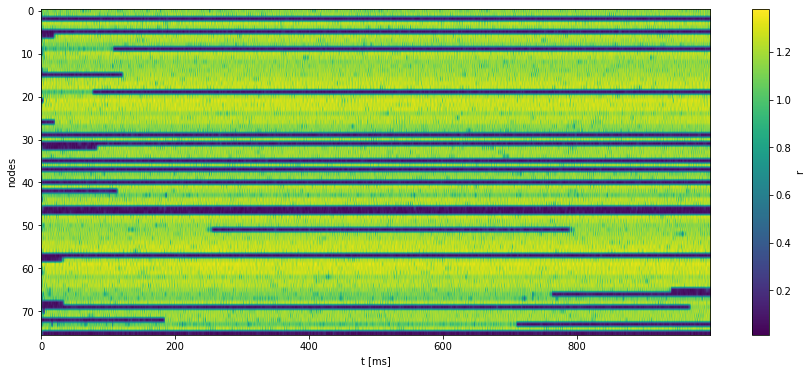

In [93]:
fig, ax = plt.subplots()
im = ax.imshow(tavg_d[:,0,:,0].T, aspect='auto')
ax.set(ylabel='nodes', xlabel='t [ms]')
fig.colorbar(im,label='r')

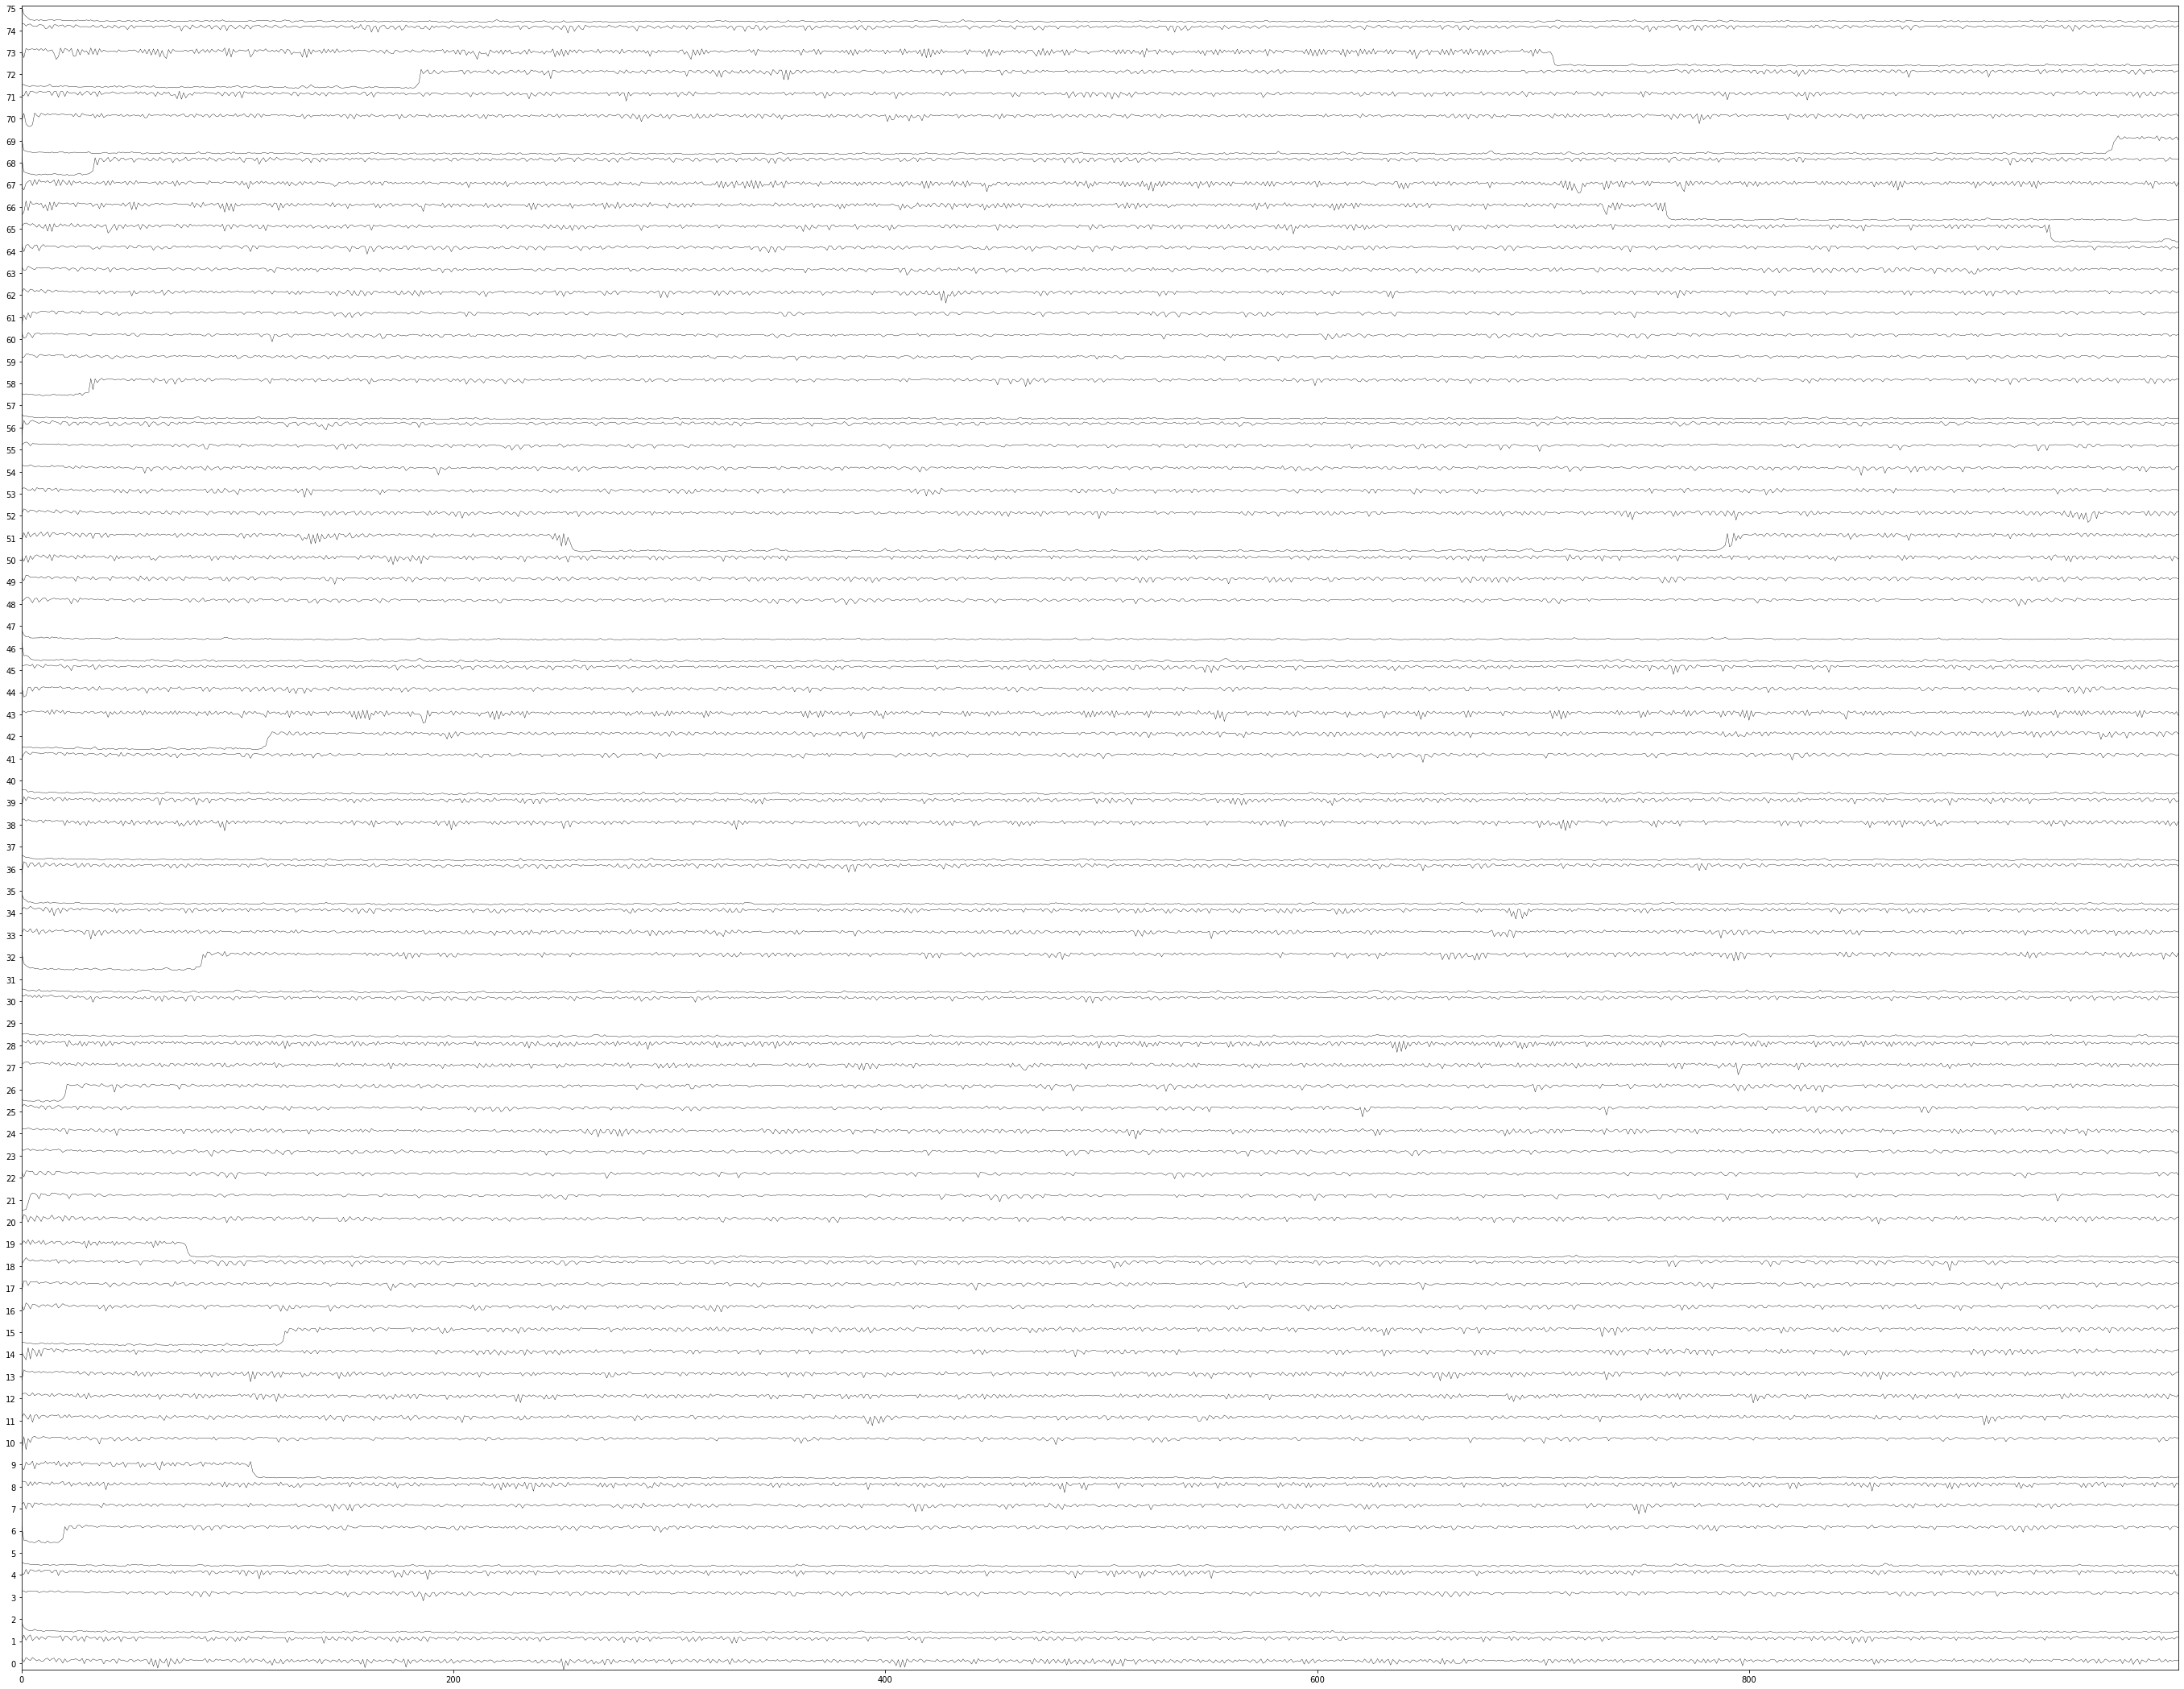

In [94]:
plot_ts_stack(tavg_d[:,0,:,0])

Now for slower system.

In [100]:
def rescale_nsigma(sig, tau):
    sig_r = sig * 1/(tau**4)
    sig_V = 2 * sig * 1/(tau**2)
    return  np.r_[sig_r, sig_V]

In [136]:
conn_speed=2.0
dt=0.1
seed=42
nsigma=0.1
eta=-4.6
J=14.5
Delta=0.7
tau=12

In [137]:
G=0.7

conn = connectivity.Connectivity.from_file() # default 76 regions 
conn.speed = np.array([conn_speed])  
np.fill_diagonal(conn.weights, 0.)
conn.weights = conn.weights/np.max(conn.weights)
conn.configure()

sim = simulator.Simulator(
    model=models.MontbrioPazoRoxin(
        eta   = np.r_[eta],
        J     = np.r_[J],
        Delta = np.r_[Delta],
        tau = np.r_[tau],
    ),
    connectivity=conn,
    coupling=coupling.Scaling(
      a=np.r_[G]
    ),
    conduction_speed=conn_speed,
    integrator=integrators.HeunStochastic(
      dt=dt,
      noise=noise.Additive(
          nsig=rescale_nsigma(nsigma,tau),
          noise_seed=seed
      )
    ),
    monitors=[
      monitors.TemporalAverage(period=1.),    
      monitors.ProgressLogger(period=100)
    ]
)

sim.configure();

WARNING  File 'hemispheres' not found in ZIP.


In [138]:
(tavg_t, tavg_d), _ = sim.run(simulation_length=1000)

   INFO  step 1 time 0.0001 s
   INFO  step 1001 time 0.1001 s
   INFO  step 2001 time 0.2001 s
   INFO  step 3001 time 0.3001 s
   INFO  step 4001 time 0.4001 s
   INFO  step 5001 time 0.5001 s
   INFO  step 6001 time 0.6001 s
   INFO  step 7001 time 0.7001 s
   INFO  step 8001 time 0.8001 s
   INFO  step 9001 time 0.9001 s


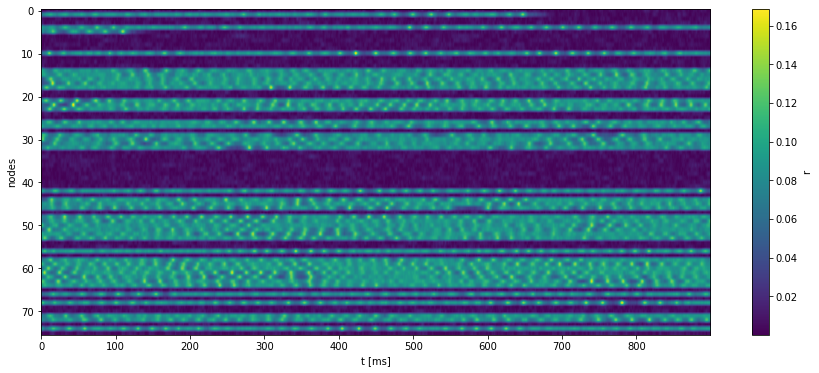

In [139]:
fig, ax = plt.subplots()
im = ax.imshow(tavg_d[100:,0,:,0].T, aspect='auto')
ax.set(ylabel='nodes', xlabel='t [ms]')
fig.colorbar(im,label='r')

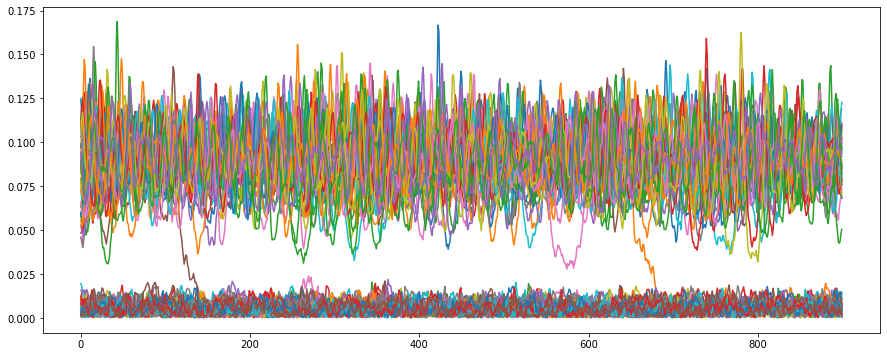

In [210]:
plt.plot(tavg_d[100:,0,:,0]);

In [158]:
tavg, bold = run_fast(sim)

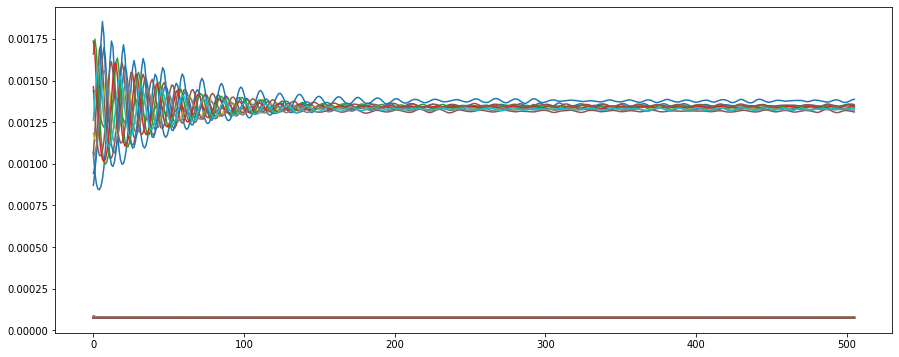

In [164]:
plt.plot(tavg[70:,0,:]);

In [217]:
tavg, bold = run_fast(sim, nh=1024*16,nto=2)

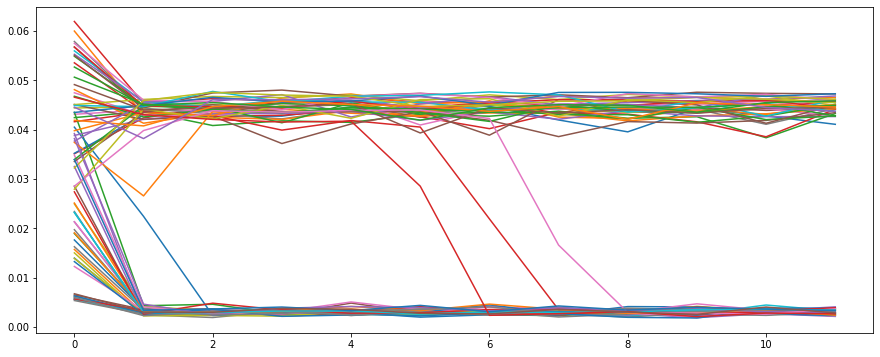

In [220]:
plt.plot(tavg[:,0,:]);

In [221]:
tavg, bold = run_fast(sim, nh=1024*16,nto=16)

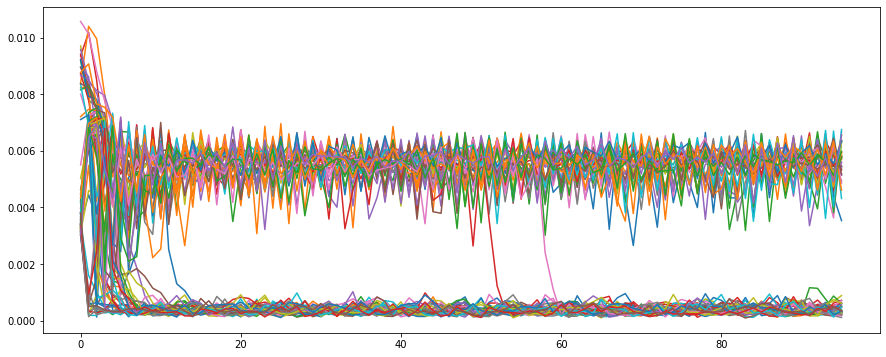

In [222]:
plt.plot(tavg[:,0,:]);